# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__
1) Which outcome (education, health or happiness) do living conditions affect the most?

2) Is there a correlation between precarious housing and health (both physical and mental) status?

3) In what ways do precarious living conditions affect children scholarship (if they do) ? Which age group is most impacted ?


## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
# Make custom palettes for seaborn
colors = ['#BDDBD3','#B8B8FF'] #opal & lilac
#colors_light = ['#CAE2DC','#C2C2FF'] #opal & lilac
colors_light = ['#8FA3F8','#B6F3C9'] #light blue & light green
#colors_light = ['#CAF6D8','#B2BFFA'] #mint & lavender
#colors_dark=['#62A87C','#FDE74C']  #green & yellow
colors_dark = ['#9999FF','#B0D4CB'] #lilac & opal
customLight = sns.color_palette(colors_light)
customDark = sns.color_palette(colors_dark)
customPalette = sns.color_palette(colors)

In [3]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [4]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','SEX','UAGE','SITE','STATE','UREGION','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS','CSPECED']
family = ['UFAMSTR','UMH2','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS','NDEPRESA']
health = ['BDISBL','BHLTHN']
activities = ['UACT','UACTNEG','UACTPOS']
eco = ['UHINS4'] 

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0 or x >5) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + eco]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing/unusable values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the NLESSONS variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18), UBPIB(6-18), UMH2(25-100), UACT(0-3), UAGG(4-16) & NDEPRESA(1-4) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UMH2n'] = child['UMH2'].apply(lambda x: (x-25)/(100-25) if x != -1 else x)
child.loc[:,'UACTn'] = child['UACT'].apply(lambda x: (x)/(3-0) if x != -1 else x)
child.loc[:,'UAGG'] = child['UAGG'].apply(lambda x: (16-x) if x != -1 else x)
child.loc[:,'UAGGn'] = child['UAGG'].apply(lambda x: x/(16-4) if x != -1 else x)
child.loc[:,'NDEPRESA'] = child['NDEPRESA'].apply(lambda x: (4-x) if x != -1 else x)
child.loc[:,'NDEPRESAn'] = child['NDEPRESA'].apply(lambda x: x/(4-1) if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,SEX,UAGE,SITE,STATE,UREGION,HHID,UENG,UENGNEG,...,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NDEPRESAn
0,5561612801,1,1,3,15,WI,2,55616128,-1,-1,...,1,0.75,-1.000000,0.00,-1.0,-1.000000,0.933333,-1.000000,0.000000,0.000000
1,5470400001,2,0,14,15,WI,2,54704000,8,1,...,2,1.50,0.333333,0.00,-1.0,0.416667,0.666667,0.333333,0.000000,0.000000
2,5787427204,2,1,9,15,WI,2,57874272,12,0,...,2,2.00,0.666667,0.50,1.0,-1.000000,1.000000,0.666667,0.083333,0.000000
3,5410681601,1,0,4,15,WI,2,54106816,-1,-1,...,2,2.50,-1.000000,0.25,-1.0,-1.000000,0.666667,-1.000000,0.000000,0.000000
4,5051721601,2,1,17,15,WI,2,50517216,13,0,...,2,1.25,0.750000,0.25,-1.0,0.833333,0.253333,0.333333,0.416667,0.666667


In [6]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal children, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal children, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal children, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal children, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 47)
fc2: (10925, 47)
fc3:(11087, 47)
fc23: (22012, 47)
True


## Propensity score

__Living conditions indicator :__

In [8]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [9]:
# Variables used for precarity indicator (economics and relationship with family)
# NB CHOICE OF WORDS : PRECARITY NOT VERY ACCURATE
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']

df_prec = df_NN(fc23,'PERSID',prec)

In [10]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them -> WE CAN CHOOSE WEIGHTS LATER TO TUNE THE INDEX
# NB performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
norm_prec.loc[:,negative] *= -1

weights = [2.5,7,0.5,0.5,0.25,2]

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.dot(weights)

# Choose a threshold to consider a household 'precarious' or not (we chose the value 1)
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < 0 else 0)

norm_prec['living_ind'].describe()

count    21515.000000
mean         1.371713
std          1.704213
min         -7.708333
25%          0.214286
50%          1.691964
75%          2.847222
max          4.187500
Name: living_ind, dtype: float64

In [11]:
# Merge this new column with whole df without NaNs
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')

**PS with `bool0_5` as a treatment**

In [12]:
# logistic regression for CHLD0_5
# NB changed to fc23 rather than child, removed BHLTHN from PS calculation
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','UHINS4']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + UHINS4'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.497091
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21450
Model:                          Logit   Df Residuals:                    21434
Method:                           MLE   Df Model:                           15
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.1650
Time:                        23:49:41   Log-Likelihood:                -10663.
converged:                       True   LL-Null:                       -12770.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.6158      0.229    -20.122      0.000      -5.065      -4.166
UREGION[T.2]    -0.0148      0.049     -0.302      0.762      -0.111       0.081
UREGION[T.3]     0.0214      0.050      0.432      0.666      -0.076       0.118
UREGION[T.4]    -0.0025      0.051     -0.049      0.961      -0.102       0.097
SEX              0.0012      0.034      0.035      0.972      -0.066       0.068
UFAMSTR         -0.0130      0.020     -0.658      0.510      -0.052       0.026
UMH2             0.0065      0.001      4.665      0.000       0.004       0.009
UMHIGDEG        -0.0246      0.009     -2.699      0.007      -0.042      -0.007
UAGG             0.0290      0.010      2.993      0.003       0.010       0.048
UHHCOUNT         0.7202      0.029     24.504      0.000       0.663       0.778
U_SOCPOV        -0.2046      0.018    -11.664      0.000      -0.239      -0.170
MNBEDRMS        -0.1368      0.042     -3.285      0.001      -0.218      -0.055
MOWNRENT         0.2278      0.039      5.900      0.000       0.152       0.303
OVERCROWDING     0.3172      0.073      4.319      0.000       0.173       0.461
BDISBL           0.2702      0.054      5.031      0.000       0.165       0.375
UHINS4          -0.0892      0.020     -4.408      0.000      -0.129      -0.050
================================================================================
"""

In [13]:
# from the logistic regression, compute the predicted propensity from the training set
pred05 = res1.predict(df_05.copy())
df_05.loc[:,'PS'] = pred05

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## PS matching

### Useful methods

In [14]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [15]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally matched propensity scores
def optimatch(ctrl_df,trtm_df,alpha=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): # we iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < alpha):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

#### Matching with `bool0_5`

In [16]:
# separates the treated and untreated population
trtm0_5 = df_05[df_05.bool0_5 == 1].reset_index(drop=True)
ctrl0_5 = df_05[df_05.bool0_5 == 0].reset_index(drop=True)

# Perform matching between treated and non-treated samples
df_child05 = optimatch(trtm0_5,ctrl0_5,0.001)

print(f'Number of treated subjects (children) : {trtm0_5.shape[0]} \n\
Number of control subjects (no children) : {ctrl0_5.shape[0]} \n\
Number of matched pairs : {df_child05.shape[0]/2}')

Number of treated subjects (children) : 6060 
Number of control subjects (no children) : 15390 
Number of matched pairs : 5156.0


In [17]:
# plots the matched vs unmatched repartition of 1) PS and 2) a random variable var
def plotPS(unmatched,treatment,var,ret=False):
    
    treated = unmatched[unmatched[treatment]==1].sample(frac=1).reset_index(drop=True)
    control = unmatched[unmatched[treatment]==0].sample(frac=1).reset_index(drop=True)
    
    matched = optimatch(treated,control,0.001)
    
    print(f'Number of treated subjects : {treated.shape[0]} \n\
Number of control subjects : {control.shape[0]} \n\
Number of matched pairs : {matched.shape[0]/2}')
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.histplot(ax = axes[0], data=unmatched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette= customDark)
    sns.histplot(ax = axes[1], data=matched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette = customDark)
    plt.suptitle('Propensity score distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.kdeplot(ax=axes[0], data=unmatched, x=var, hue=treatment, palette=['r','g'], shade=True, common_norm=False)
    sns.kdeplot(ax=axes[1], data=matched, x=var, hue=treatment, palette=['r','g'], shade=True)
    axes[0].set_xlim(0,5)
    axes[1].set_xlim(0,5)
    plt.suptitle(var+' distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    if(ret):
        return matched

Number of treated subjects : 6060 
Number of control subjects : 15390 
Number of matched pairs : 5168.0


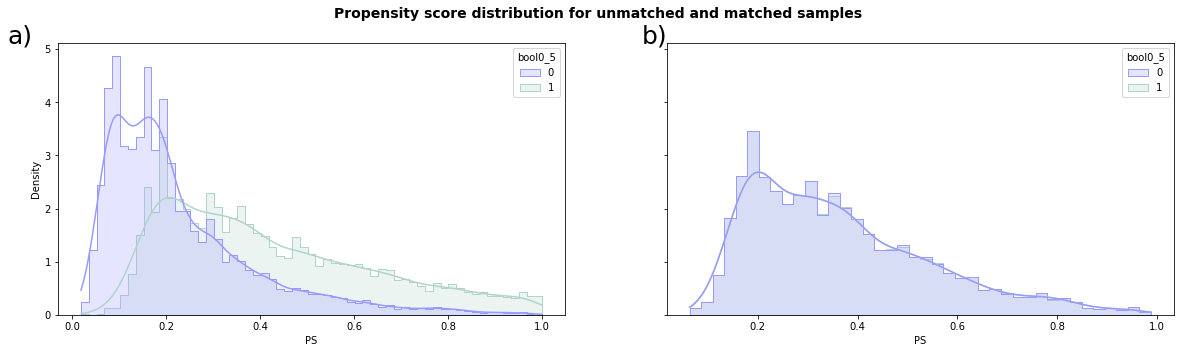

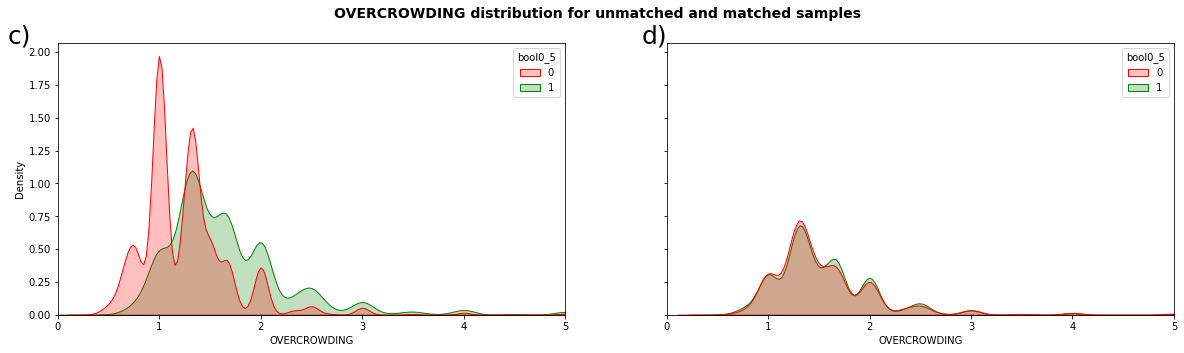

In [18]:
plotPS(df_05,'bool0_5','OVERCROWDING')

# similar curves with matching !

**PS with `NLESSONS` as treatment**

In [19]:
# logistic regression for NLESSONS
# NB removed BHLTHN
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS',
             'MOWNRENT','OVERCROWDING','BDISBL','CSPECED','UHINS4']
df_lessons = df_NN(fc23,'NLESSONS',predictors)

log_model_L = 'NLESSONS ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + \
+ UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + CSPECED + UHINS4'

log_L = smf.logit(formula=log_model_L, data=df_lessons)
res_L = log_L.fit()
res_L.summary()

Optimization terminated successfully.
         Current function value: 0.599905
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               NLESSONS   No. Observations:                21263
Model:                          Logit   Df Residuals:                    21246
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                 0.06086
Time:                        23:50:03   Log-Likelihood:                -12756.
converged:                       True   LL-Null:                       -13582.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -3.3033      0.212    -15.572      0.000      -3.719      -2.888
UREGION[T.2]    -0.2659      0.043     -6.226      0.000      -0.350      -0.182
UREGION[T.3]    -0.3959      0.044     -8.920      0.000      -0.483      -0.309
UREGION[T.4]    -0.2148      0.045     -4.804      0.000      -0.302      -0.127
SEX              0.7412      0.031     24.275      0.000       0.681       0.801
UFAMSTR          0.1303      0.018      7.248      0.000       0.095       0.165
UMH2             0.0054      0.001      4.266      0.000       0.003       0.008
UMHIGDEG         0.0998      0.008     12.031      0.000       0.084       0.116
UAGG            -0.0133      0.009     -1.491      0.136      -0.031       0.004
UHHCOUNT        -0.0744      0.026     -2.882      0.004      -0.125      -0.024
U_SOCPOV         0.1784      0.016     10.855      0.000       0.146       0.211
MNBEDRMS         0.1240      0.035      3.517      0.000       0.055       0.193
MOWNRENT         0.0612      0.036      1.679      0.093      -0.010       0.133
OVERCROWDING    -0.0508      0.071     -0.720      0.471      -0.189       0.087
BDISBL           0.2083      0.059      3.548      0.000       0.093       0.323
CSPECED          0.1808      0.058      3.131      0.002       0.068       0.294
UHINS4          -0.0705      0.019     -3.795      0.000      -0.107      -0.034
================================================================================
"""

In [20]:
pred_L = res_L.predict(df_lessons)
df_lessons.loc[:,'PS'] = pred_L

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 7158 
Number of control subjects : 14105 
Number of matched pairs : 6890.0


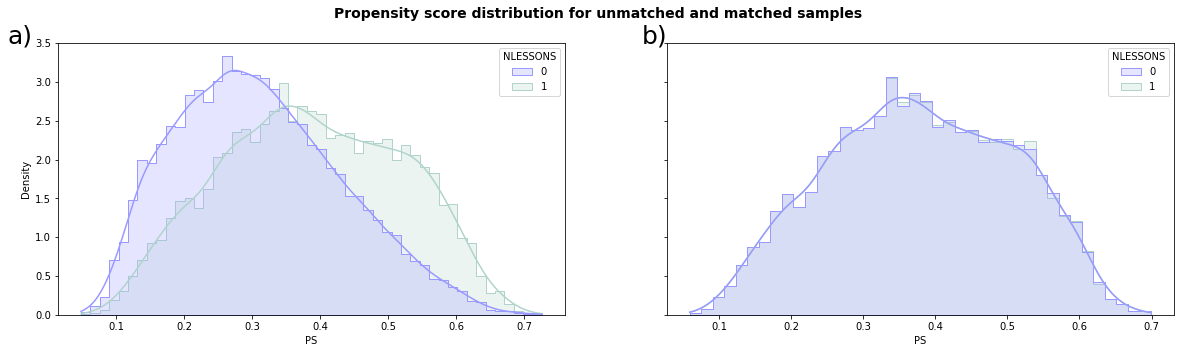

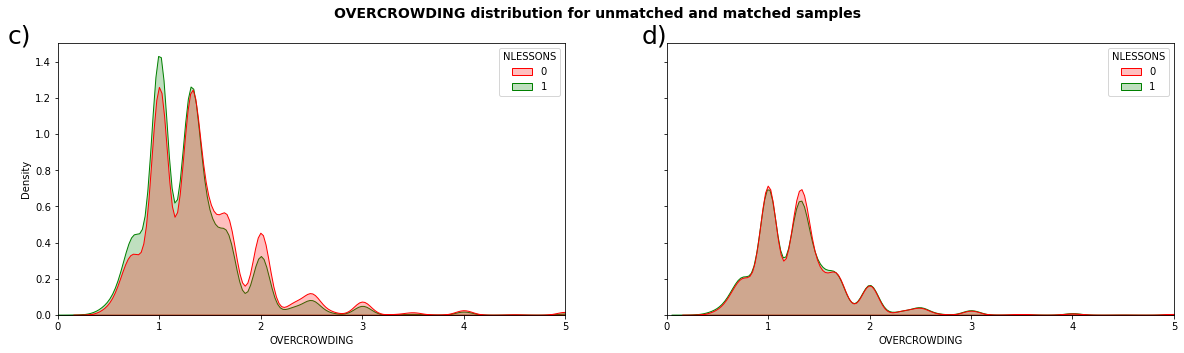

In [21]:
plotPS(df_lessons,'NLESSONS','OVERCROWDING')

**PS with `precarious` as treatment**

In [22]:
# logistic regression for precarious
# NB removed UBPIA BHLTHN UENG
predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS',
             'OVERCROWDING','BDISBL','CSPECED','UACT','CSPECED']
df_prec_raw = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UMHIGDEG\
+ UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT + CSPECED'

log_prec = smf.logit(formula=log_model_prec, data=df_prec_raw)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.385589
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21317
Model:                          Logit   Df Residuals:                    21304
Method:                           MLE   Df Model:                           12
Date:                Mon, 14 Dec 2020   Pseudo R-squ.:                  0.2657
Time:                        23:50:18   Log-Likelihood:                -8219.6
converged:                       True   LL-Null:                       -11194.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.1442      0.287     -0.502      0.616      -0.707       0.419
UREGION[T.2]    -0.2333      0.060     -3.910      0.000      -0.350      -0.116
UREGION[T.3]     0.4243      0.056      7.607      0.000       0.315       0.534
UREGION[T.4]     0.0734      0.060      1.226      0.220      -0.044       0.191
SEX              0.1324      0.040      3.330      0.001       0.054       0.210
UAGE             0.0121      0.006      2.139      0.032       0.001       0.023
UMHIGDEG         0.0168      0.010      1.643      0.100      -0.003       0.037
UHHCOUNT         0.1807      0.053      3.419      0.001       0.077       0.284
MNBEDRMS        -0.8585      0.085    -10.143      0.000      -1.024      -0.693
OVERCROWDING     1.3963      0.150      9.331      0.000       1.103       1.690
BDISBL          -0.3663      0.066     -5.591      0.000      -0.495      -0.238
CSPECED         -0.2227      0.066     -3.383      0.001      -0.352      -0.094
UACT            -0.4732      0.022    -21.590      0.000      -0.516      -0.430
================================================================================
"""

In [23]:
pred_prec = res_prec.predict(df_prec_raw)
df_prec_raw.loc[:,'PS'] = pred_prec

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 4660 
Number of control subjects : 16657 
Number of matched pairs : 3476.0


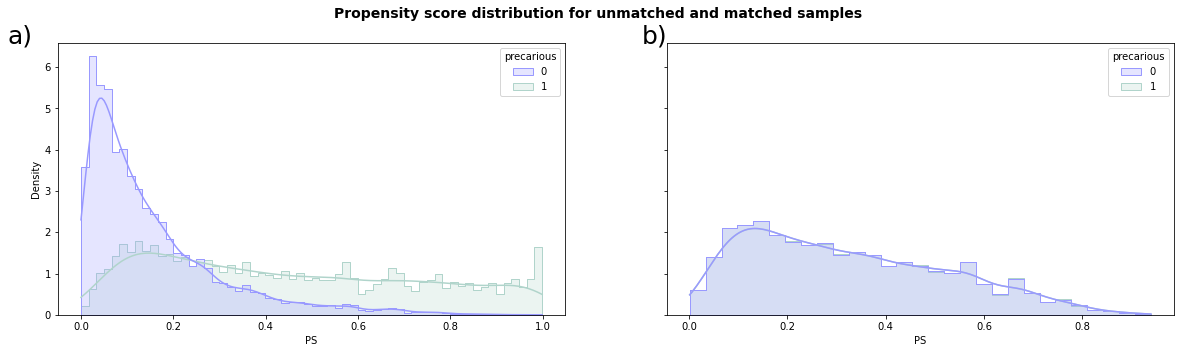

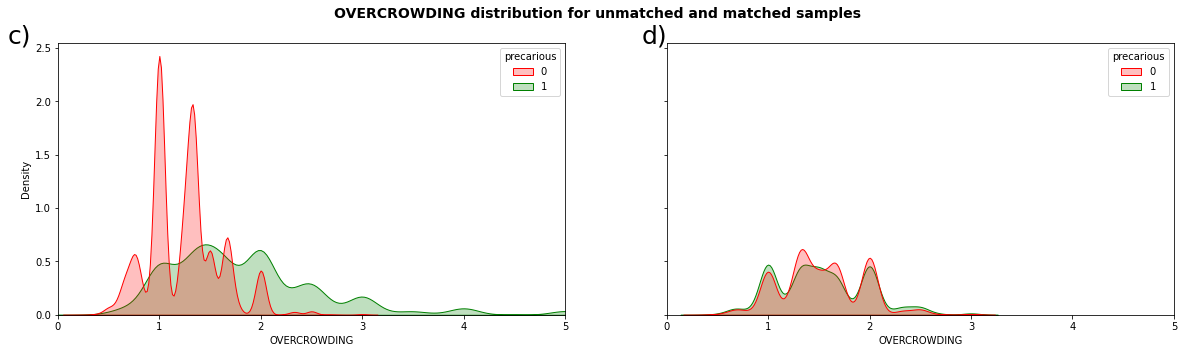

In [24]:
df_prec = plotPS(df_prec_raw,'precarious','OVERCROWDING',True)

In [25]:
means_prec = df_prec_raw.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGn'][0] - means_prec['UENGn'][1]))
means_prec

Diff of mean = 0.0706770388198511


,PERSTYPE,SEX,UAGE,UENG,UENGNEG,UENGPOS,NLESSONS,CSPECED,UFAMSTR,UMH2,...,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NDEPRESAn,bool0_5,PS
precarious,,,,,,,,,,,,,,,,,,,,,
0,2.0,0.490725,11.642913,12.751156,0.194333,0.337035,0.365612,1.887135,3.424326,80.431230,...,0.723485,0.154365,-0.115732,-0.057909,0.738142,0.525365,0.170129,0.222329,0.236777,0.153929
1,2.0,0.493348,11.155150,11.931330,0.292060,0.229828,0.227039,1.825107,2.377253,74.680258,...,0.652808,0.270440,-0.034996,-0.188805,0.661142,0.342489,0.212160,0.317597,0.442918,0.449786


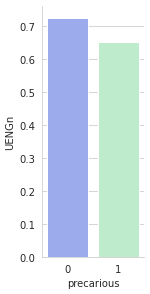

In [26]:
with sns.axes_style("whitegrid"):
    sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGn',kind='bar', palette=customLight, height=4, aspect=0.5)

In [27]:
means_prec = df_prec.groupby('precarious').mean()
print('Diff of mean = ' +str(means_prec['UENGn'][0] - means_prec['UENGn'][1]))

Diff of mean = 0.03373130034522598


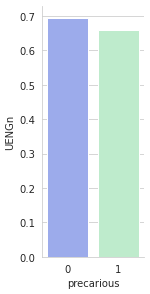

In [28]:
with sns.axes_style("whitegrid"):
    sns.catplot(data=means_prec.reset_index(),x='precarious',y='UENGn',kind='bar',palette=customLight, height=4, aspect=0.5)

### General description of precariousness

<AxesSubplot:xlabel='UFAMSTR', ylabel='Probability'>

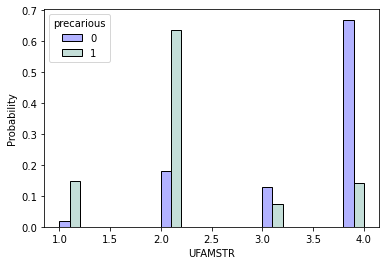

In [29]:
sns.histplot(x='UFAMSTR', hue='precarious', stat='probability', data=df_NN(df_prec,'precarious', ['UFAMSTR']),
             common_norm=False, multiple='dodge', palette=customDark)
# Quelles structures familiales amènent la précarité?

## Linear regression models

In [30]:
# returns a regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## Education

In [31]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1426.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           5.68e-59
Time:                        23:50:27   Log-Likelihood:                -48807.
No. Observations:               21054   AIC:                         9.764e+04
Df Residuals:                   21041   BIC:                         9.774e+04
Df Model:                          12                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        9.6149      0.237     40.498   

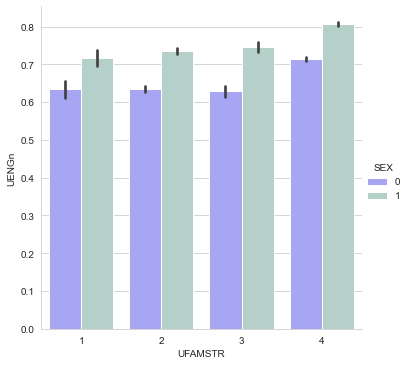

In [32]:
sns.set_style('whitegrid')
sns.catplot(y='UENGn', x='UFAMSTR', hue='SEX', kind='bar', palette=customDark, data=df_NN(fc23,outcome,predictors))

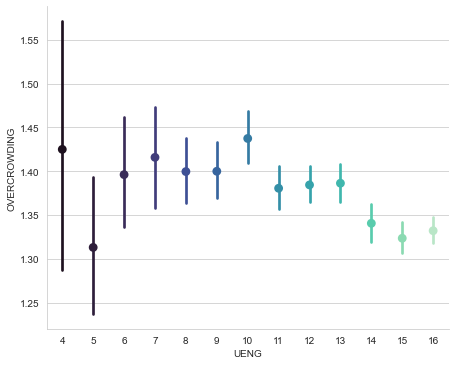

In [33]:
sns.catplot(x='UENG', y='OVERCROWDING',kind='point', palette='mako', data=df_NN(fc23,outcome,predictors),height=5,aspect=1.25)

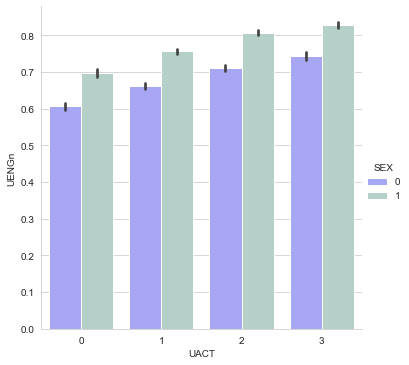

In [34]:
sns.catplot(y='UENGn', x='UACT', hue='SEX', palette=customDark, kind='bar', data=df_NN(fc23,outcome,predictors))

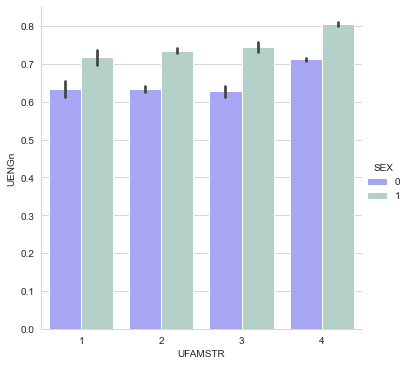

In [35]:
var='UENGn'
sns.catplot(x='UFAMSTR', y=var, hue='SEX', kind='bar', palette=customDark, data=df_NN(fc23,var,['UFAMSTR']))
# filles + scolaires, plus la structure familiale est confortable, meilleur est l'engagment scolaire positif

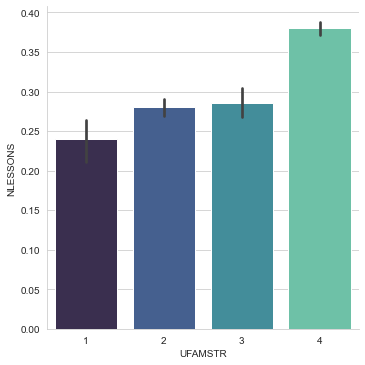

In [36]:
var='NLESSONS'
sns.catplot(x='UFAMSTR', y=var, kind='bar', palette='mako', data=df_NN(child,var,['UFAMSTR']))
# Plus la structure familiale est confortable, + les lessons sont prises

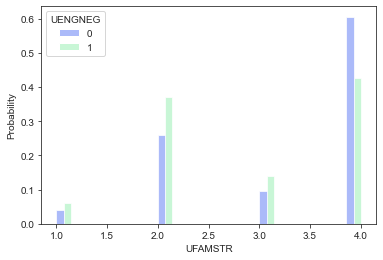

In [37]:
with sns.axes_style("ticks"):
    sns.histplot(x='UFAMSTR', hue='UENGNEG', stat='probability', data=df_NN(fc23,'UENGNEG', ['UFAMSTR']),
                 common_norm=False, multiple='dodge', palette=customLight)
# dans quelles familles sont distribués les enfants peu engagés

## Health

In [38]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     327.1
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           1.48e-42
Time:                        23:50:31   Log-Likelihood:                -26866.
No. Observations:               21437   AIC:                         5.376e+04
Df Residuals:                   21425   BIC:                         5.385e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.5091      0.103     24.463   

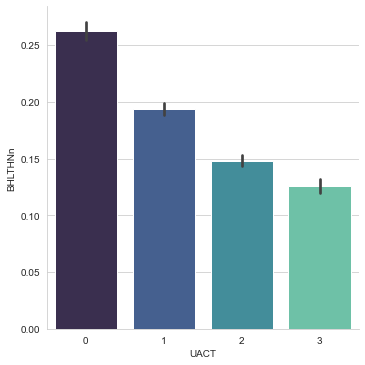

In [39]:
sns.catplot(x='UACT', y='BHLTHNn',kind='bar', palette='mako', data=df_NN(fc23,outcome,predictors))

## Mental health

In [40]:
outcome = 'NDEPRESAn'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              NDEPRESAn   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     1491.
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           6.90e-59
Time:                        23:50:32   Log-Likelihood:                 3986.5
No. Observations:               10604   AIC:                            -7949.
Df Residuals:                   10592   BIC:                            -7862.
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.4787      0.019     79.485   

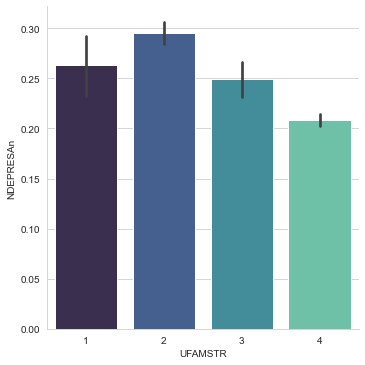

In [41]:
sns.catplot(y='NDEPRESAn', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

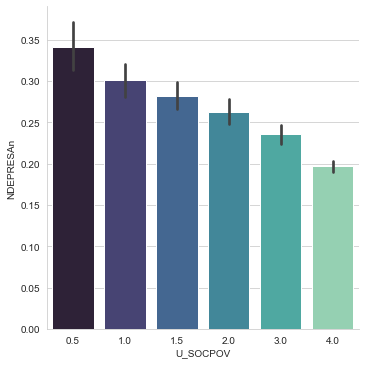

In [42]:
sns.catplot(y='NDEPRESAn', x='U_SOCPOV', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

**fc2**

In [43]:
outcome = 'UBPIA'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc2,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIA   R-squared:                       0.241
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     619.5
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.09e-49
Time:                        23:50:33   Log-Likelihood:                -21244.
No. Observations:               10566   AIC:                         4.251e+04
Df Residuals:                   10554   BIC:                         4.260e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       13.7257      0.265     51.717   

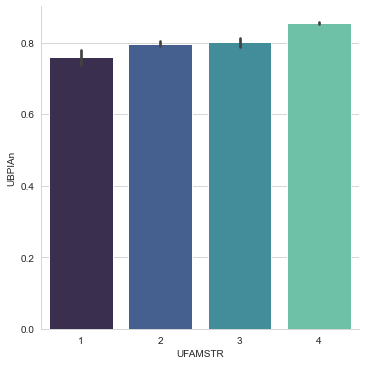

In [44]:
sns.catplot(y='UBPIAn', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

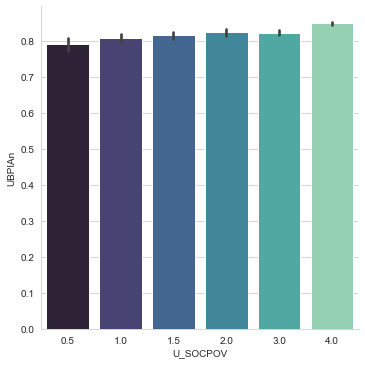

In [45]:
sns.catplot(y='UBPIAn', x='U_SOCPOV', kind='bar', palette='mako', data=df_NN(fc2,outcome,predictors))

**fc3**

In [46]:
outcome = 'UBPIB'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc3,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  UBPIB   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     664.5
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           3.66e-50
Time:                        23:50:34   Log-Likelihood:                -21979.
No. Observations:               10777   AIC:                         4.398e+04
Df Residuals:                   10765   BIC:                         4.407e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.8760      0.235     54.794   

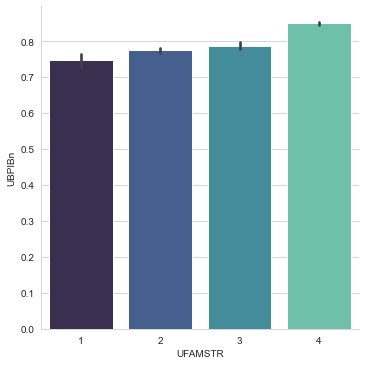

In [47]:
sns.catplot(y='UBPIBn', x='UFAMSTR', kind='bar', palette='mako', data=df_NN(fc3,outcome,predictors))

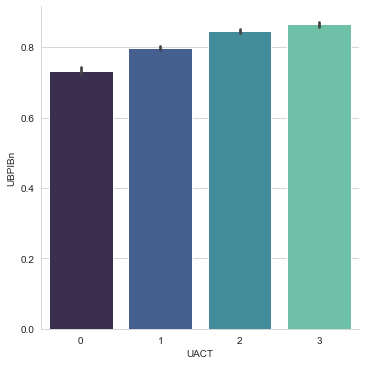

In [48]:
sns.catplot(y='UBPIBn', x='UACT', kind='bar', palette='mako', data=df_NN(fc3,outcome,predictors))

**Parents**

In [49]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     48.37
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           4.37e-20
Time:                        23:50:35   Log-Likelihood:            -1.3326e+05
No. Observations:               33501   AIC:                         2.665e+05
Df Residuals:                   33493   BIC:                         2.666e+05
Df Model:                           7                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       71.8627      1.023     70.229   

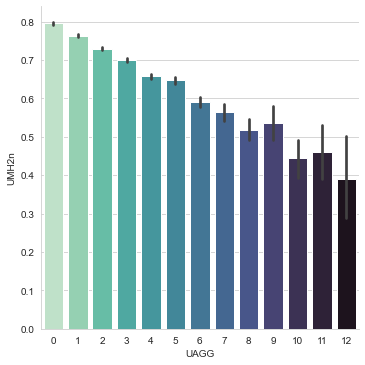

In [50]:
var='UMH2n'
sns.catplot(x='UAGG', y=var, kind='bar', palette='mako_r', data=df_NN(child,var,['UAGG']))
# mental health des parents directement corrélée avec le fait que le gamin soit insupportable (UAGG bas = insupportable)

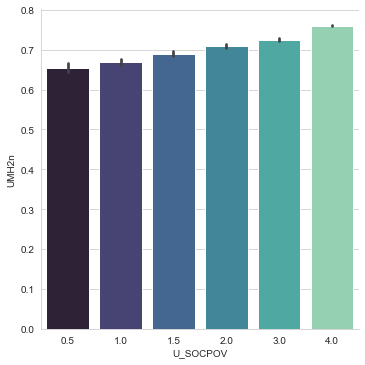

In [51]:
var='UMH2n'
sns.catplot(x='U_SOCPOV', y=var, kind='bar', palette='mako', data=df_NN(child,var,['U_SOCPOV']))
# mental health des parents directement corrélée avec l'aisance financière'

## Conclusion Q1

Looking at the whole model, we can say that mental health is most influenced by housing conditions.

## Average treatment effect on schooling, health & happiness

Using the matched pairs we can compute the average treatment (young child and precarity) effect on our variables of interest.

__ATE of having a young child (or children) in the household__

In [52]:
# Computes CI
def CI(alpha, data):    
    ci = sms.DescrStatsW(data).tconfint_mean(alpha)
    return ci

In [53]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return 'Not significant'

In [54]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    pairs_difference = df_match.loc[df_match[treatment_var]==1,voi].values - df_match.loc[df_match[treatment_var]==0,voi].values
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, pairs_difference), CI(0.05, pairs_difference), CI(0.01, pairs_difference)]
    star = stars(ci)
    
    return ate, ci, star

In [55]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    
    for var in list_voi:
        print(var)
        ate, ci, star = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99,
                           'Significance': stars})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [56]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var, interest_var, fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, interest_var)
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [57]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3, elinewidth=1,
                     label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('nATE (with 95% CI)', fontsize=12)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Normalized average treatment effect (nATE) of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend()
    plt.show()

__ATE of taking lessons outside of school__

__ATE of `precarious` household__

In [58]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','NDEPRESAn','UAGGn'])
ate_precarious[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 6756 / 6873
BHLTHNn
Number of matched subjects: 6860 / 6952
UMH2n
Number of matched subjects: 6846 / 6942
UACTn
Number of matched subjects: 6858 / 6952
NDEPRESAn
Number of matched subjects: 6846 / 6943
UAGGn
Number of matched subjects: 6878 / 6952
UBPIAn
Number of matched subjects: 3122 / 3617
UBPIBn
Number of matched subjects: 2878 / 3301


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.033131,[-0.042377 ; -0.023885],[-0.044150 ; -0.022112],[-0.047615 ; -0.018647],***
1,BHLTHNn,0.074636,[0.065214 ; 0.084057],[0.063409 ; 0.085863],[0.059878 ; 0.089393],***
2,UMH2n,-0.058639,[-0.066492 ; -0.050786],[-0.067997 ; -0.049280],[-0.070940 ; -0.046337],***
3,UACTn,0.005638,[-0.004125 ; 0.015401],[-0.005996 ; 0.017272],[-0.009655 ; 0.020931],Not significant
4,NDEPRESAn,0.068653,[0.057246 ; 0.080061],[0.055059 ; 0.082247],[0.050784 ; 0.086522],***
5,UAGGn,0.024692,[0.017675 ; 0.031709],[0.016330 ; 0.033054],[0.013700 ; 0.035684],***
6,UBPIAn,-0.027813,[-0.039018 ; -0.016608],[-0.041167 ; -0.014459],[-0.045371 ; -0.010255],***
7,UBPIBn,-0.022759,[-0.034554 ; -0.010964],[-0.036816 ; -0.008702],[-0.041242 ; -0.004276],***


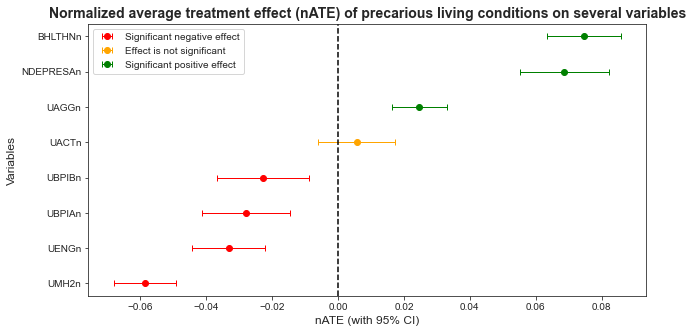

In [59]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green'])

sns.set_style('ticks')

plot_ATE(ate_precarious,'precarious')

### 3) fc2 or fc3

In [60]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','NDEPRESAn','UAGGn'],fc2=True)
ate_precarious_fc2[['variable','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 3124 / 3609
BHLTHNn
Number of matched subjects: 3126 / 3633
UMH2n
Number of matched subjects: 3122 / 3628
UACTn
Number of matched subjects: 3138 / 3633
NDEPRESAn
Number of matched subjects: 3144 / 3630
UAGGn
Number of matched subjects: 3150 / 3633
UBPIAn
Number of matched subjects: 3124 / 3617


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.024541,[-0.036841 ; -0.012241],[-0.039200 ; -0.009882],[-0.043815 ; -0.005267],***
1,BHLTHNn,0.062860,[0.049391 ; 0.076329],[0.046808 ; 0.078912],[0.041754 ; 0.083966],***
2,UMH2n,-0.060286,[-0.071445 ; -0.049128],[-0.073585 ; -0.046987],[-0.077771 ; -0.042801],***
3,UACTn,0.008073,[-0.006705 ; 0.022851],[-0.009539 ; 0.025685],[-0.015083 ; 0.031229],Not significant
4,NDEPRESAn,0.061917,[0.045096 ; 0.078738],[0.041870 ; 0.081964],[0.035559 ; 0.088275],***
5,UAGGn,0.017672,[0.007717 ; 0.027627],[0.005807 ; 0.029536],[0.002072 ; 0.033271],***
6,UBPIAn,-0.027689,[-0.038884 ; -0.016494],[-0.041031 ; -0.014347],[-0.045231 ; -0.010147],***


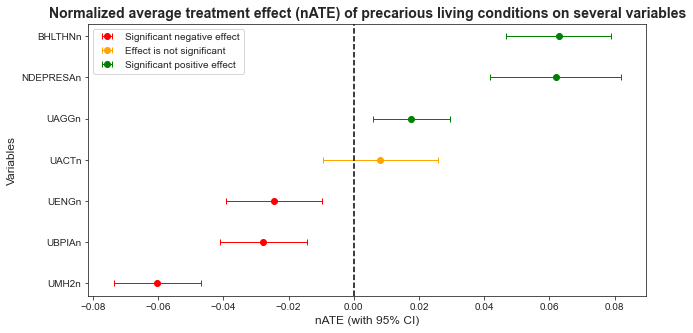

In [61]:
plot_ATE(ate_precarious_fc2,'precarious')

In [62]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious', ['UENGn','BHLTHNn','UMH2n','UACTn','NDEPRESAn','UAGGn'], fc3=True)
ate_precarious_fc3[['variable','ATE','90% CI','95% CI','99% CI','Significance']].head()

UENGn
Number of matched subjects: 2836 / 3264
BHLTHNn
Number of matched subjects: 2876 / 3319
UMH2n
Number of matched subjects: 2860 / 3314
UACTn
Number of matched subjects: 2870 / 3319
NDEPRESAn
Number of matched subjects: 2872 / 3313
UAGGn
Number of matched subjects: 2886 / 3319
UBPIBn
Number of matched subjects: 2866 / 3301


,variable,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,-0.035614,[-0.050646 ; -0.020581],[-0.053529 ; -0.017698],[-0.059171 ; -0.012056],***
1,BHLTHNn,0.079451,[0.064777 ; 0.094124],[0.061963 ; 0.096939],[0.056456 ; 0.102445],***
2,UMH2n,-0.061063,[-0.073296 ; -0.048830],[-0.075643 ; -0.046483],[-0.080233 ; -0.041892],***
3,UACTn,0.006969,[-0.008714 ; 0.022651],[-0.011722 ; 0.025659],[-0.017607 ; 0.031544],Not significant
4,NDEPRESAn,0.077066,[0.059555 ; 0.094577],[0.056196 ; 0.097936],[0.049625 ; 0.104507],***


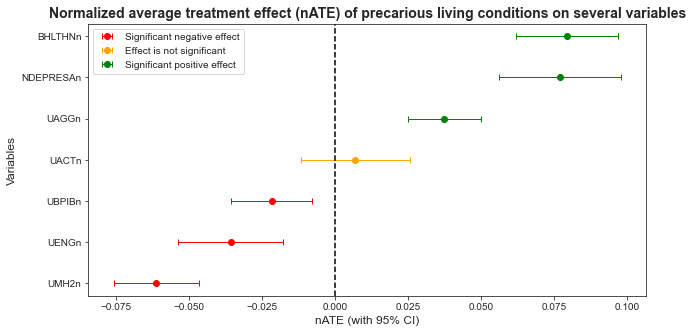

In [63]:
plot_ATE(ate_precarious_fc3,'precarious')

In [64]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
ci90s = []
ci95s = []
ci99s = []
for i in range (0,ate_precarious_fc3.variable.size):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    #ci qui est la diff des coordonnées des ci de fc2 et fc3 : 
    # ci=[(ate_precarious_fc3['ci90'][i][0] - ate_precarious_fc2['ci90'][i][0],ate_precarious_fc3['ci90'][i][1] - ate_precarious_fc2['ci90'][i][1]),(ate_precarious_fc3['ci95'][i][0] - ate_precarious_fc2['ci95'][i][0],ate_precarious_fc3['ci95'][i][1] - ate_precarious_fc2['ci95'][i][1]),(ate_precarious_fc3['ci99'][i][0] - ate_precarious_fc2['ci99'][i][0],ate_precarious_fc3['ci99'][i][1] - ate_precarious_fc2['ci99'][i][1])]
   
    #ci qui utilise la moitié de la taille de ci que les précédents: 
    ci = [(ate_precarious_fc3['ci90'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci90'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate),(ate_precarious_fc3['ci95'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci95'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate),(ate_precarious_fc3['ci99'][i][0]/2-ate_precarious_fc3['ATE'][i]/2+ate,ate_precarious_fc3['ci99'][i][1]/2-ate_precarious_fc3['ATE'][i]/2+ate)]
    
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

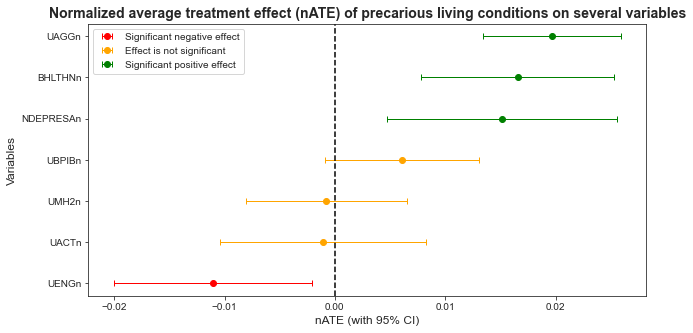

In [65]:
# Set the binary color cycle
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red','green']) 

plot_ATE(age_diff,'precarious')

#### fc3 - fc2 pour les valeurs, aucune des deux méthodes de CI me convient mais la première donne un meilleur truc (visuellement en tt cas) \\
     Plus le point est à adroite, + la variable en question est impactée par la précarité pour les 12-17. Plus c'est à gauche, plus la variable en question est impactée par la précarité pour les 6-11.

### Effect of family structure on school

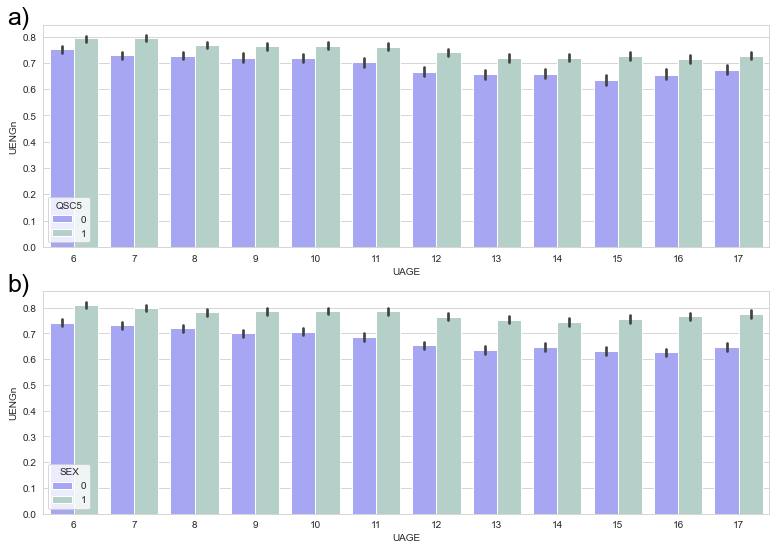

In [66]:
var='UENGn'
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(2, figsize=(13,9))
    axes[0].text(-0.05,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    sns.barplot(ax=axes[0], x='UAGE', y=var, hue = 'QSC5', palette=customDark, data=df_NN(fc23,var,['UAGE','QSC5']))
    sns.barplot(ax=axes[1], x='UAGE', y=var, hue = 'SEX', palette=customDark, data=df_NN(fc23,var,['UAGE','SEX']))
plt.show()

**a)** Across all ages, having a family income under 2x the poverty line reduces scholar involvement.    
**b)** Overall, we can see a light reduction in school involvement with age. This reduction, however, is only significant with boys. N.B. we can also conclude that across all ages groups, girls are significantly more involved at school than boys. 

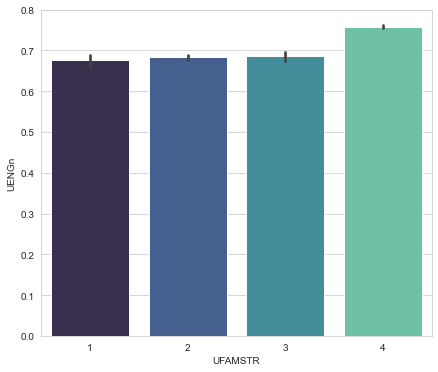

In [67]:
with sns.axes_style("whitegrid"):
    fig,ax = plt.subplots(figsize=(7,6))
    sns.barplot(y='UENGn', x='UFAMSTR', palette='mako', data=df_NN(fc23,var,['UFAMSTR']))
plt.show()

Being under the supervision of two parents significantly improves scholar involvement. On the other hand, involvement is roughly the same for children brought up with no parents, 1 parent, or in a step-family.